<a href="https://colab.research.google.com/github/LUUTHIENXUAN/Shellnet-in-Tensorflow2/blob/main/Shellnet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point cloud segmentation with ShellNet: Efficient Point Cloud Convolutional Neural Networks using Concentric Shells Statistics

**Author:** [hkust-vgd
](https://github.com/hkust-vgd/shellnet)<br>
**Date created:** 2021/11/21<br>
**Last modified:** 2021/11/26<br>
**Description:** Implementation of ShellNet for ModelNet10 classification.

https://github.com/hkust-vgd/shellnet/blob/master/shellconv.py

## Introduction

A "point cloud" is an important type of data structure for storing geometric shape data.
Due to its irregular format, it's often transformed into
regular 3D voxel grids or collections of images before being used in deep learning applications,
a step which makes the data unnecessarily large.
The PointNet family of models solves this problem by directly consuming point clouds, respecting
the permutation-invariance property of the point data. The PointNet family of
models provides a simple, unified architecture
for applications ranging from **object classification**, **part segmentation**, to
**scene semantic parsing**.

In this example, we demonstrate the implementation of the PointNet architecture
for shape segmentation.

### References

- [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593)
- [Point cloud classification with PointNet](https://keras.io/examples/vision/pointnet/)
- [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025)

## Imports

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

#!pip install tensorflow==2.6.0
#!pip install tensorflow-gpu==2.6.*
#!pip install keras== 2.6.0
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

2.7.0


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so*

lrwxrwxrwx 1 root root        29 Dec 15  2020 /usr/lib/x86_64-linux-gnu/libcudnn.so -> /etc/alternatives/libcudnn_so
lrwxrwxrwx 1 root root        17 Oct 27  2019 /usr/lib/x86_64-linux-gnu/libcudnn.so.7 -> libcudnn.so.7.6.5
-rw-r--r-- 1 root root 428711256 Oct 27  2019 /usr/lib/x86_64-linux-gnu/libcudnn.so.7.6.5
lrwxrwxrwx 1 root root        17 Nov  6  2020 /usr/lib/x86_64-linux-gnu/libcudnn.so.8 -> libcudnn.so.8.0.5
-rw-r--r-- 1 root root    158264 Nov  6  2020 /usr/lib/x86_64-linux-gnu/libcudnn.so.8.0.5


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [ ]:
#Get compile flags from TensorFlow.
tf.sysconfig.get_compile_flags()
# output: ['-I/usr/local/lib/python3.7/dist-packages/tensorflow/include',
# '-D_GLIBCXX_USE_CXX11_ABI=0']

['-I/usr/local/lib/python3.7/dist-packages/tensorflow/include',
 '-D_GLIBCXX_USE_CXX11_ABI=0',
 '-DEIGEN_MAX_ALIGN_BYTES=64']

In [ ]:
#Get linking flags from TensorFlow.
tf.sysconfig.get_link_flags()
# output: ['-L/usr/local/lib/python3.7/dist-packages/tensorflow',
# '-l:libtensorflow_framework.so.2']

['-L/usr/local/lib/python3.7/dist-packages/tensorflow',
 '-l:libtensorflow_framework.so.2']

In [ ]:
%%writefile zero_out.cc

#include "tensorflow/core/framework/op.h"
#include "tensorflow/core/framework/shape_inference.h"

using namespace tensorflow;

REGISTER_OP("ZeroOut")
    .Input("to_zero: int32")
    .Output("zeroed: int32")
    .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
      c->set_output(0, c->input(0));
      return Status::OK();
    });

Writing zero_out.cc


In [ ]:
! g++ -std=c++14 -shared \
    zero_out.cc \
    -o zero_out.so \
    -fPIC \
    -I/usr/local/lib/python3.7/dist-packages/tensorflow/include \
    -D_GLIBCXX_USE_CXX11_ABI=0 \
    -L/usr/local/lib/python3.7/dist-packages/tensorflow \
    -l:libtensorflow_framework.so.2 \
    -O2

In file included from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/partial_tensor_shape.h:20:0,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/attr_value_util.h:23,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/node_def_util.h:23,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/full_type_util.h:24,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/op.h:24,
                 from zero_out.cc:2:
/usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/tensor_shape.h:305:22: warning: ‘tensorflow::int64’ is deprecated: Use int64_t instead. [-Wdeprecated-declarations]
   gtl::InlinedVector<int64, 4> dim_sizes() const;
                      ^~~~~
In file included from /usr/local/lib/python3.7/dist-p

In [ ]:
# look for data directory
! ls -l 

total 28
drwxr-xr-x 1 root root  4096 Dec  3 14:33 sample_data
-rw-r--r-- 1 root root   353 Dec 30 02:05 zero_out.cc
-rwxr-xr-x 1 root root 19720 Dec 30 02:05 zero_out.so


In [ ]:
tf.load_op_library("./zero_out.so")

<module '2adc7dff99aed96d6c87cd167238cb94f3cbbe44'>

## Downloading Dataset

The [ShapeNet dataset](https://shapenet.org/) is an ongoing effort to establish a richly-annotated,
large-scale dataset of 3D shapes. **ShapeNetCore** is a subset of the full ShapeNet
dataset with clean single 3D models and manually verified category and alignment
annotations. It covers 55 common object categories, with about 51,300 unique 3D models.

For this example, we use one of the 12 object categories of
[PASCAL 3D+](http://cvgl.stanford.edu/projects/pascal3d.html),
included as part of the ShapenetCore dataset.

In [ ]:
dataset_url = "https://git.io/JiY4i"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

1078935552/1078925405 [==============================] - 16s 0us/step


## Loading the dataset

We parse the dataset metadata in order to easily map model categories to their
respective directories and segmentation classes to colors for the purpose of
visualization.

In [ ]:
with open("/tmp/.keras/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

In this example, we train PointNet to segment the parts of an `Airplane` model.

In [ ]:
points_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points".format(
    metadata["Airplane"]["directory"]
)
labels_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points_label".format(
    metadata["Airplane"]["directory"]
)
LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

## Structuring the dataset



We generate the following in-memory data structures from the Airplane point clouds and
their labels:

- `point_clouds` is a list of `np.array` objects that represent the point cloud data in
the form of x, y and z coordinates. Axis 0 represents the number of points in the
point cloud, while axis 1 represents the coordinates. `all_labels` is the list
that represents the label of each coordinate as a string (needed mainly for
visualization purposes).
- `test_point_clouds` is in the same format as `point_clouds`, but doesn't have
corresponding the labels of the point clouds.
- `all_labels` is a list of `np.array` objects that represent the point cloud labels
for each coordinate, corresponding to the `point_clouds` list.
- `point_cloud_labels` is a list of `np.array` objects that represent the point cloud
labels for each coordinate in one-hot encoded form, corresponding to the `point_clouds`
list.

In [ ]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))
for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        # Apply one-hot encoding to the dense label representation.
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)

100%|██████████| 4045/4045 [04:11<00:00, 16.09it/s]


Next, we take a look at some samples from the in-memory arrays we just generated:

In [ ]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[1408].shape: (2631, 3)
point_cloud_labels[1408].shape: (2631, 5)
all_labels[1408][0]: engine 	point_cloud_labels[1408][0]: [0. 0. 0. 1. 0.] 

all_labels[1408][1]: wing 	point_cloud_labels[1408][1]: [1. 0. 0. 0. 0.] 

all_labels[1408][2]: body 	point_cloud_labels[1408][2]: [0. 1. 0. 0. 0.] 

all_labels[1408][3]: body 	point_cloud_labels[1408][3]: [0. 1. 0. 0. 0.] 

all_labels[1408][4]: wing 	point_cloud_labels[1408][4]: [1. 0. 0. 0. 0.] 

point_clouds[1489].shape: (2631, 3)
point_cloud_labels[1489].shape: (2631, 5)
all_labels[1489][0]: body 	point_cloud_labels[1489][0]: [0. 1. 0. 0. 0.] 

all_labels[1489][1]: body 	point_cloud_labels[1489][1]: [0. 1. 0. 0. 0.] 

all_labels[1489][2]: wing 	point_cloud_labels[1489][2]: [1. 0. 0. 0. 0.] 

all_labels[1489][3]: body 	point_cloud_labels[1489][3]: [0. 1. 0. 0. 0.] 

all_labels[1489][4]: wing 	point_cloud_labels[1489][4]: [1. 0. 0. 0. 0.] 

point_clouds[3026].shape: (2631, 3)
point_cloud_labels[3026].shape: (2631, 5)
all_labels[302

Now, let's visualize some of the point clouds along with their labels.

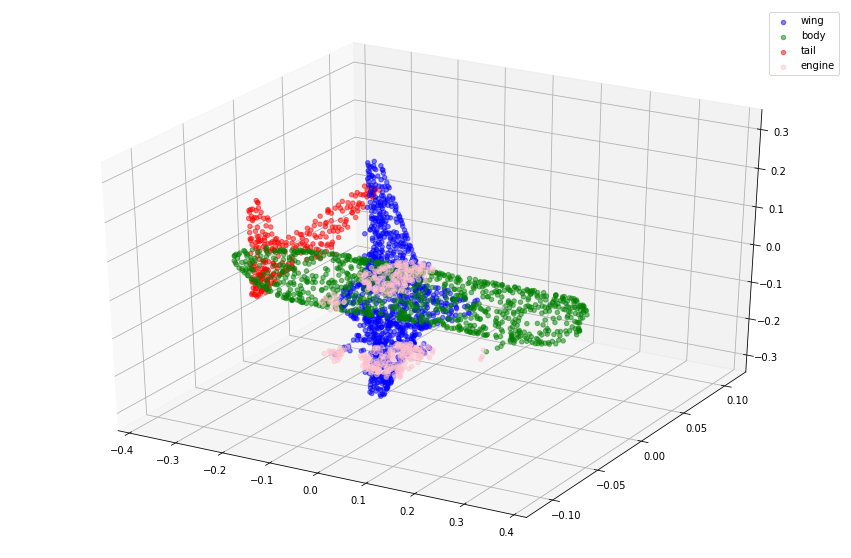

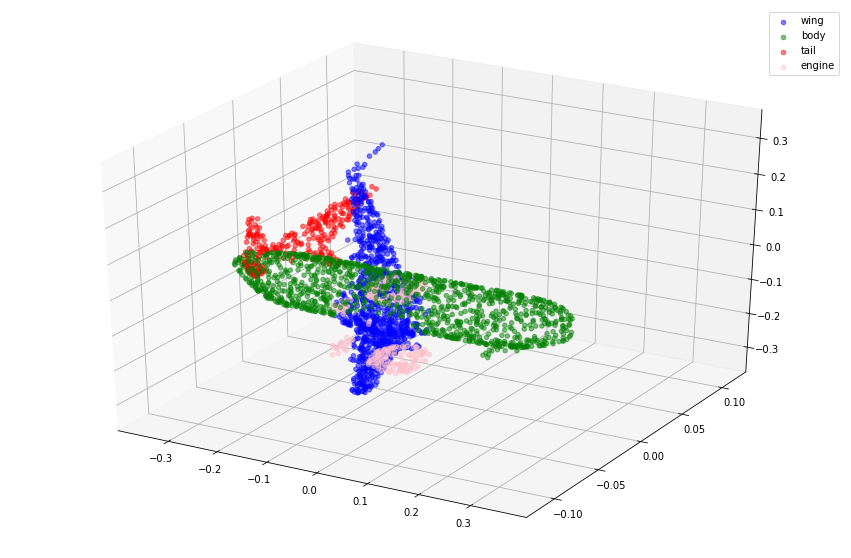

In [ ]:
def visualize_data(point_cloud, labels):
  df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
  fig = plt.figure(figsize=(15, 10))
  ax = plt.axes(projection="3d")
  for index, label in enumerate(LABELS):
    c_df = df[df["label"] == label]
    try:
      ax.scatter(c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index])
    except IndexError:
      pass
  ax.legend()
  plt.show()


visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

### Preprocessing

Note that all the point clouds that we have loaded consist of a variable number of points,
which makes it difficult for us to batch them together. In order to overcome this problem, we
randomly sample a fixed number of points from each point cloud. We also normalize the
point clouds in order to make the data scale-invariant.

In [ ]:
for index in tqdm(range(len(point_clouds))):
  current_point_cloud = point_clouds[index]
  current_label_cloud = point_cloud_labels[index]
  current_labels = all_labels[index]
  num_points = len(current_point_cloud)
  # Randomly sampling respective indices.
  sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
  # Sampling points corresponding to sampled indices.
  sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
  # Sampling corresponding one-hot encoded labels.
  sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
  # Sampling corresponding labels for visualization.
  sampled_labels = np.array([current_labels[i] for i in sampled_indices])
  # Normalizing sampled point cloud.
  norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
  norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
  point_clouds[index] = norm_point_cloud
  point_cloud_labels[index] = sampled_label_cloud
  all_labels[index] = sampled_labels

100%|██████████| 3694/3694 [00:08<00:00, 423.55it/s]


Let's visualize the sampled and normalized point clouds along with their corresponding
labels.

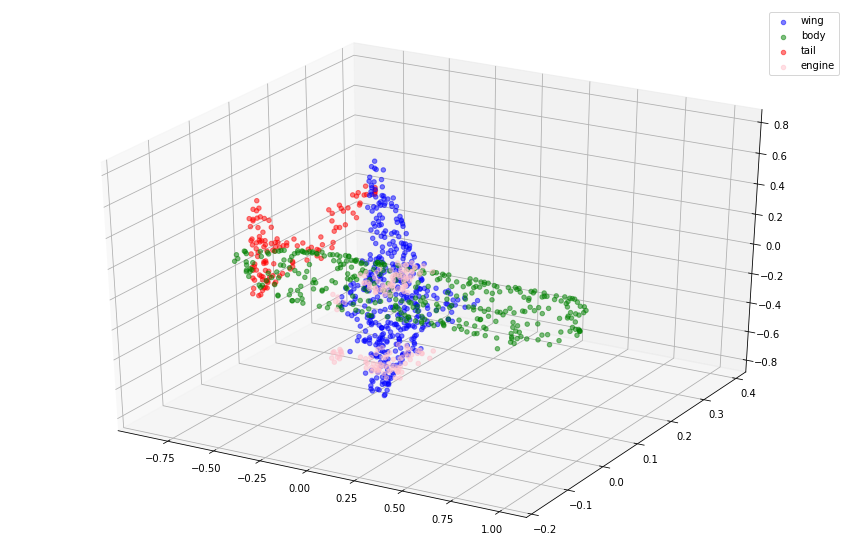

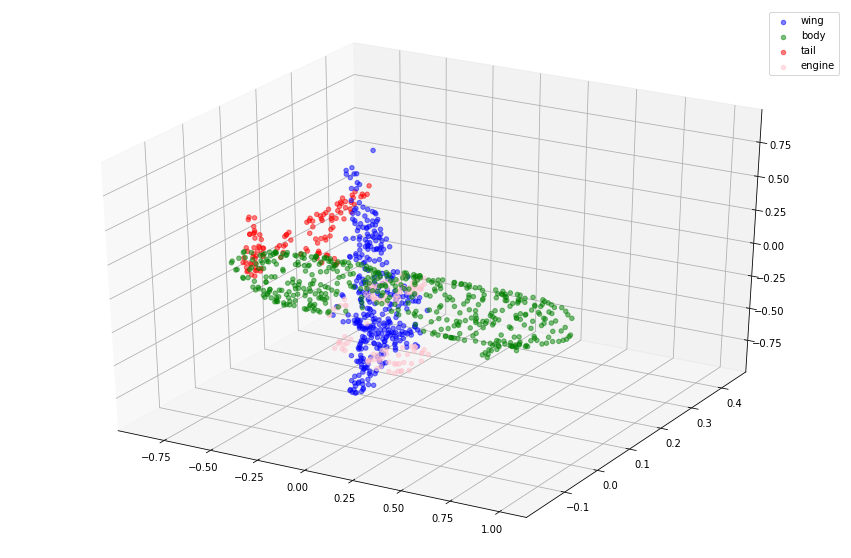

In [ ]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

### Creating TensorFlow datasets

We create `tf.data.Dataset` objects for the training and validation data.
We also augment the training point clouds by applying random jitter to them.

In [ ]:
def load_data(point_cloud_batch, label_cloud_batch):
  point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
  label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
  return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
  noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
    )
  point_cloud_batch += noise[:, :, :3]
  return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
  dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
  dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
  dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch_size=BATCH_SIZE)
  dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
  return dataset


split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 2955
Num train point cloud labels: 2955
Num val point clouds: 739
Num val point cloud labels: 739
Train Dataset: <ParallelMapDataset shapes: ((None, 1024, 3), (None, 1024, 5)), types: (tf.float64, tf.float32)>
Validation Dataset: <BatchDataset shapes: ((None, 1024, 3), (None, 1024, 5)), types: (tf.float64, tf.float32)>


## Build a model Shellnet

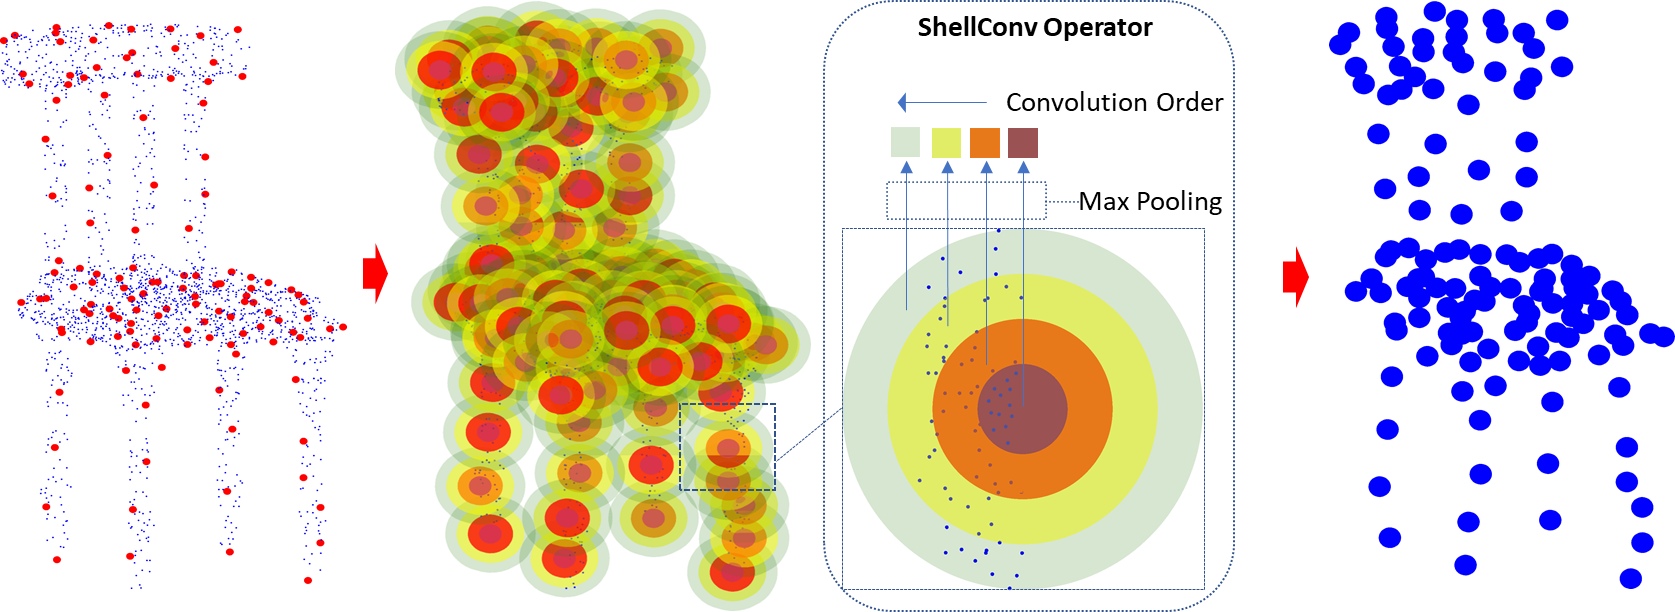

In [ ]:
import math
import random
import itertools
import numpy as np
import tensorflow as tf
from numpy import linalg as LA

!pip install transforms3d
from transforms3d.euler import euler2mat

     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59373 sha256=220ef1807f6d11df360f8a1d291d193d41ed0003a1a327be85eb1ae743b8c8ac
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d


In [ ]:
def get_indices(batch_size, sample_num, point_num, pool_setting=None):
  """
  the returned indices will be used by tf.gather_nd
  """
  if not isinstance(point_num, np.ndarray):
    point_nums = np.full((batch_size), point_num)
  else:
    point_nums = point_num

  indices = []
  for i in range(batch_size):
    pt_num = point_nums[i]
    if pool_setting is None:
      pool_size = pt_num
    else:
      if isinstance(pool_setting, int):
        pool_size = min(pool_setting, pt_num)
      elif isinstance(pool_setting, tuple):
        pool_size = min(random.randrange(pool_setting[0], pool_setting[1]+1), pt_num)
    if pool_size > sample_num:
      choices = np.random.choice(pool_size, sample_num, replace=False)
    else:
      choices = np.concatenate((np.random.choice(pool_size, pool_size, replace=False),
                                np.random.choice(pool_size, sample_num - pool_size, replace=True)))
    if pool_size < pt_num:
      choices_pool = np.random.choice(pt_num, pool_size, replace=False)
      choices = choices_pool[choices]
    choices = np.expand_dims(choices, axis=1)
    choices_2d = np.concatenate((np.full_like(choices, i), choices), axis=1)
    indices.append(choices_2d)
  return np.stack(indices)

def gauss_clip(mu, sigma, clip):
  v = random.gauss(mu, sigma)
  v = max(min(v, mu + clip * sigma), mu - clip * sigma)
  return v

def uniform(bound):
  return bound * (2 * random.random() - 1)

def scaling_factor(scaling_param, method):
  try:
    scaling_list = list(scaling_param)
    return random.choice(scaling_list)
  except:
    if method == 'g':
      return gauss_clip(1.0, scaling_param, 3)
    elif method == 'u':
      return 1.0 + uniform(scaling_param)

def rotation_angle(rotation_param, method):
  try:
    rotation_list = list(rotation_param)
    return random.choice(rotation_list)
  except:
    if method == 'g':
      return gauss_clip(0.0, rotation_param, 3)
    elif method == 'u':
      return uniform(rotation_param)

def get_xforms(xform_num, rotation_range=(0, 0, 0, 'u'), scaling_range=(0.0, 0.0, 0.0, 'u'), order='rxyz'):
  xforms = np.empty(shape=(xform_num, 3, 3))
  rotations = np.empty(shape=(xform_num, 3, 3))
  for i in range(xform_num):
    rx = rotation_angle(rotation_range[0], rotation_range[3])
    ry = rotation_angle(rotation_range[1], rotation_range[3])
    rz = rotation_angle(rotation_range[2], rotation_range[3])
    rotation = euler2mat(rx, ry, rz, order)

    sx = scaling_factor(scaling_range[0], scaling_range[3])
    sy = scaling_factor(scaling_range[1], scaling_range[3])
    sz = scaling_factor(scaling_range[2], scaling_range[3])
    scaling = np.diag([sx, sy, sz])

    xforms[i, :] = scaling * rotation
    rotations[i, :] = rotation
  return xforms, rotations

def augment(points, xforms, range=None):
  points_xformed = tf.matmul(points, xforms, name='points_xformed')
  if range is None:
    return points_xformed

  jitter_data = range * tf.random_normal(tf.shape(points_xformed), name='jitter_data')
  jitter_clipped = tf.clip_by_value(jitter_data, -5 * range, 5 * range, name='jitter_clipped')
  return points_xformed + jitter_clipped

def distance_matrix(A):
  """
  # A shape is (N, C)
  """
  r = tf.reduce_sum(A * A, 1, keepdims=True)
  m = tf.matmul(A, tf.transpose(A))
  D = r - 2 * m + tf.transpose(r)
  return D

def batch_distance_matrix(A):
  # A shape is (N, P, C)
  r = tf.reduce_sum(A * A, axis=2, keepdims=True)
  m = tf.matmul(A, tf.transpose(A, perm=(0, 2, 1)))
  D = r - 2 * m + tf.transpose(r, perm=(0, 2, 1))
  return D

def batch_distance_matrix_general(A, B):
  """
  # A shape is (N, P_A, C), B shape is (N, P_B, C)
  # D shape is (N, P_A, P_B)
  """
  r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
  r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
  m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
  D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
  return D


In [ ]:
def unique_with_inverse(x):
  y, idx = tf.unique(x)
  num_segments = tf.shape(y)[0]
  num_elems = tf.shape(x)[0]
  return (y, idx,  tf.unsorted_segment_min(tf.range(num_elems), idx, num_segments))

def find_duplicate_columns(A):
  """
  # A shape is (N, P, C)
  """
  #N = tf.shape(A)[0]
  #P = tf.shape(A)[1]
  N = A.shape[0]
  P = A.shape[1]
  indices_duplicated = np.full((N, 1, P), 1, dtype=np.int32)
  #indices_duplicated = tf.fill((N, 1, P), 1)
  
  for idx in range(N):
    _, indices = np.unique(A[idx], return_index=True, axis=0)
    #tmp = tf.reshape(A[idx], shape=(-1,))
    #_, indices = tf.unique(tmp)
    indices_duplicated[idx, :, indices] = 0
  return indices_duplicated

def prepare_for_unique_top_k(D, A):
  """
  # add a big value to duplicate columns
  """
  indices_duplicated = tf.py_function(find_duplicate_columns, [A], tf.int32)
  #indices_duplicated = find_duplicate_columns(A)
  
  D += tf.reduce_max(D) * tf.cast(indices_duplicated, tf.float32)

def knn_indices(points, k, sort=True, unique=True):
  """
  # return shape is (N, P, K, 2)
  """
  points_shape = tf.shape(points)
  batch_size = points_shape[0]
  point_num = points_shape[1]

  D = batch_distance_matrix(points)
  if unique:
    prepare_for_unique_top_k(D, points)
  distances, point_indices = tf.nn.top_k(-D, k=k, sorted=sort)
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, point_num, k, 1))
  indices = tf.concat([batch_indices, tf.expand_dims(point_indices, axis=3)], axis=3)
  return -distances, indices

#@tf.function(jit_compile=True) 
def knn_indices_general(queries, points, k, sort=True, unique=True):
  """
  # return shape is (N, P, K, 2)
  """
  queries_shape = tf.shape(queries)
  batch_size = queries_shape[0]
  point_num = queries_shape[1]
  tmp_k = 0
  D = batch_distance_matrix_general(queries, points)
  if unique: prepare_for_unique_top_k(D, points)
  _, point_indices = tf.nn.top_k(-D, k=k+tmp_k, sorted=sort)  # (N, P, K)
  # point_indices = tf.contrib.framework.argsort(D)
  # point_indices = point_indices[:,:,:k]
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, point_num, k, 1))
  indices = tf.concat([batch_indices, tf.expand_dims(point_indices[:,:,tmp_k:], axis=3)], axis=3)
  return indices

def sort_points(points, indices, sorting_method):
  """
  # indices is (N, P, K, 2)
  # return shape is (N, P, K, 2)
  """

  indices_shape = tf.shape(indices)
  batch_size = indices_shape[0]
  point_num = indices_shape[1]
  k = indices_shape[2]

  nn_pts = tf.gather_nd(points, indices)  # (N, P, K, 3)
  if sorting_method.startswith('c'):
    if ''.join(sorted(sorting_method[1:])) != 'xyz':
            print('Unknown sorting method!')
            exit()
    epsilon = 1e-8
    nn_pts_min = tf.reduce_min(nn_pts, axis=2, keepdims=True)
    nn_pts_max = tf.reduce_max(nn_pts, axis=2, keepdims=True)
    nn_pts_normalized = (nn_pts - nn_pts_min) / (nn_pts_max - nn_pts_min + epsilon)  # (N, P, K, 3)
    scaling_factors = [math.pow(100.0, 3 - sorting_method.find('x')),
                           math.pow(100.0, 3 - sorting_method.find('y')),
                           math.pow(100.0, 3 - sorting_method.find('z'))]
    scaling = tf.constant(scaling_factors, shape=(1, 1, 1, 3))
    sorting_data = tf.reduce_sum(nn_pts_normalized * scaling, axis=-1)  # (N, P, K)
    sorting_data = tf.concat([tf.zeros((batch_size, point_num, 1)), sorting_data[:, :, 1:]], axis=-1)
  elif sorting_method == 'l2':
    nn_pts_center = tf.reduce_mean(nn_pts, axis=2, keepdims=True)  # (N, P, 1, 3)
    nn_pts_local = tf.subtract(nn_pts, nn_pts_center)  # (N, P, K, 3)
    sorting_data = tf.norm(nn_pts_local, axis=-1)  # (N, P, K)
  else:
    print('Unknown sorting method!')
    exit()
  _, k_indices = tf.nn.top_k(sorting_data, k=k, sorted=True)  # (N, P, K)
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, point_num, k, 1))
  point_indices = tf.tile(tf.reshape(tf.range(point_num), (1, -1, 1, 1)), (batch_size, 1, k, 1))
  k_indices_4d = tf.expand_dims(k_indices, axis=3)
  sorting_indices = tf.concat([batch_indices, point_indices, k_indices_4d], axis=3)  # (N, P, K, 3)
  return tf.gather_nd(indices, sorting_indices)

def compute_determinant(A):
  # a b c
  # d e f
  # g h i
  # a(ei − fh) − b(di − fg) + c(dh − eg)
  return A[..., 0, 0] * (A[..., 1, 1] * A[..., 2, 2] - A[..., 1, 2] * A[..., 2, 1]) \
           - A[..., 0, 1] * (A[..., 1, 0] * A[..., 2, 2] - A[..., 1, 2] * A[..., 2, 0]) \
           + A[..., 0, 2] * (A[..., 1, 0] * A[..., 2, 1] - A[..., 1, 1] * A[..., 2, 0])

def compute_eigenvals(A):
  """
  # A shape is (N, P, 3, 3)
  # return shape is (N, P, 3)
  """
  A_11 = A[:, :, 0, 0]  # (N, P)
  A_12 = A[:, :, 0, 1]
  A_13 = A[:, :, 0, 2]
  A_22 = A[:, :, 1, 1]
  A_23 = A[:, :, 1, 2]
  A_33 = A[:, :, 2, 2]
  
  I = tf.eye(3)
  p1 = tf.square(A_12) + tf.square(A_13) + tf.square(A_23)  # (N, P)
  q = tf.trace(A) / 3  # (N, P)
  p2 = tf.square(A_11 - q) + tf.square(A_22 - q) + tf.square(A_33 - q) + 2 * p1  # (N, P)
  p = tf.sqrt(p2 / 6) + 1e-8  # (N, P)
  N = tf.shape(A)[0]
  q_4d = tf.reshape(q, (N, -1, 1, 1))  # (N, P, 1, 1)
  p_4d = tf.reshape(p, (N, -1, 1, 1))
  B = (1 / p_4d) * (A - q_4d * I)  # (N, P, 3, 3)
  r = tf.clip_by_value(compute_determinant(B) / 2, -1, 1)  # (N, P)
  phi = tf.acos(r) / 3  # (N, P)
  eig1 = q + 2 * p * tf.cos(phi)  # (N, P)
  eig3 = q + 2 * p * tf.cos(phi + (2 * math.pi / 3))
  eig2 = 3 * q - eig1 - eig3
  return tf.abs(tf.stack([eig1, eig2, eig3], axis=2))  # (N, P, 3)

def compute_eigenvectors(A):
  """
  # A shape is (N, P, 3, 3)
  # return shape is (N, P, 3,3)
  """
  # https://math.stackexchange.com/questions/2962480/general-form-for-eigenvector-of-a-3-by-3-symmetric-matrix
  N = tf.shape(A)[0]
  P = tf.shape(A)[1]
  eigvals = compute_eigenvals(A) 
    
  tmp = tf.eye(3,batch_shape=(N,P))

  d0 = tf.reshape(eigvals[:,:,0],[N,P,1,1]) 
  d1 = tf.reshape(eigvals[:,:,1],[N,P,1,1]) 
  d2 = tf.reshape(eigvals[:,:,2],[N,P,1,1]) 

  m0 = tf.multiply(d0,tmp)
  m1 = tf.multiply(d1,tmp)
  m2 = tf.multiply(d2,tmp)

  X = tf.random_uniform([N, P, 3, 1], minval=0, maxval=10,dtype=tf.float32)
    
  v0 = tf.matmul((A-m1), (A-m2))
  v0 = tf.matmul(v0,X)

  v1 = tf.matmul((A-m0), (A-m2))
  v1 = tf.matmul(v1,X)

  v2 = tf.matmul((A-m0), (A-m1))
  v2 = tf.matmul(v2,X)


  U = tf.concat([v0, v1, v2], axis=-1)
  U = tf.divide(U, tf.norm(U, axis=-2, keepdims = True))
  U = tf.transpose(U,perm=[0,1,3,2])  # to make sure that each row is a eigenvector

  return U

def compute_axis_z(A):
  # https://math.stackexchange.com/questions/2962480/general-form-for-eigenvector-of-a-3-by-3-symmetric-matrix
  N = tf.shape(A)[0]
  P = tf.shape(A)[1]
  eigvals = compute_eigenvals(A)   # the smallest is the last one
    
  tmp = tf.eye(3,batch_shape=(N,P))

  d0 = tf.reshape(eigvals[:,:,0],[N,P,1,1]) 
  d1 = tf.reshape(eigvals[:,:,1],[N,P,1,1]) 

  m0 = tf.multiply(d0,tmp)
  m1 = tf.multiply(d1,tmp)

  X = tf.random_uniform([N, P, 3, 1], minval=0, maxval=10,dtype=tf.float32)

  v2 = tf.matmul((A-m0), (A-m1))
  v2 = tf.matmul(v2,X)

  axis_z = tf.divide(v2, tf.norm(v2, axis=-2, keepdims = True))
  # U = tf.transpose(U,perm=[0,1,3,2])  # to make sure that each row is a eigenvector

  return axis_z

def compute_curvature(nn_pts):
  """
  # P shape is (N, P, 3), N shape is (N, P, K, 3)
  # return shape is (N, P)
  """

  nn_pts_mean = tf.reduce_mean(nn_pts, axis=2, keepdims=True)  # (N, P, 1, 3)
  nn_pts_demean = nn_pts - nn_pts_mean  # (N, P, K, 3)
  nn_pts_NPK31 = tf.expand_dims(nn_pts_demean, axis=-1)
  covariance_matrix = tf.matmul(nn_pts_NPK31, nn_pts_NPK31, transpose_b=True)  # (N, P, K, 3, 3)
  covariance_matrix_mean = tf.reduce_mean(covariance_matrix, axis=2)  # (N, P, 3, 3)
  eigvals = compute_eigenvals(covariance_matrix_mean)  # (N, P, 3)
  curvature = tf.reduce_min(eigvals, axis=-1) / (tf.reduce_sum(eigvals, axis=-1) + 1e-8)
  return curvature

In [ ]:
def curvature_based_sample(nn_pts, k):
  curvature = compute_curvature(nn_pts)
  _, point_indices = tf.nn.top_k(curvature, k=k, sorted=False)

  pts_shape = tf.shape(nn_pts)
  batch_size = pts_shape[0]
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1)), (1, k, 1))
  indices = tf.concat([batch_indices, tf.expand_dims(point_indices, axis=2)], axis=2)
  return indices

def random_choice_2d(size, prob_matrix):
  n_row = prob_matrix.shape[0]
  n_col = prob_matrix.shape[1]
  choices = np.ones((n_row, size), dtype=np.int32)
  for idx_row in range(n_row):
    choices[idx_row] = np.random.choice(n_col, size=size, replace=False, p=prob_matrix[idx_row])
  return choices

def inverse_density_sampling(points, k, sample_num):
  D = batch_distance_matrix(points)
  distances, _ = tf.nn.top_k(-D, k=k, sorted=False)
  distances_avg = tf.abs(tf.reduce_mean(distances, axis=-1)) + 1e-8
  prob_matrix = distances_avg / tf.reduce_sum(distances_avg, axis=-1, keepdims=True)
  point_indices = tf.py_function(random_choice_2d, [sample_num, prob_matrix], tf.int32)
  point_indices.set_shape([points.get_shape()[0], sample_num])

  batch_size = tf.shape(points)[0]
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1)), (1, sample_num, 1))
  indices = tf.concat([batch_indices, tf.expand_dims(point_indices, axis=2)], axis=2)
  return indices

###tf_ops

In [ ]:
!mkdir tf_ops

####tf_sampling

In [ ]:
!mkdir ./tf_ops/sampling

In [ ]:
%%writefile ./tf_ops/sampling/tf_sampling.cpp

/* Furthest point sampling
 * Original author: Haoqiang Fan
 * Modified by Charles R. Qi
 * All Rights Reserved. 2017.
 */
#include "tensorflow/core/framework/op.h"
#include "tensorflow/core/framework/op_kernel.h"
#include "tensorflow/core/framework/shape_inference.h"
#include "tensorflow/core/framework/common_shape_fns.h"
#include <cuda_runtime.h>

using namespace tensorflow;

REGISTER_OP("ProbSample")
  .Input("inp: float32")
  .Input("inpr: float32")
  .Output("out: int32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * ncategory
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 2, &dims1));
    ::tensorflow::shape_inference::ShapeHandle dims2; // batch_size * npoints
    TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 2, &dims2));
    // batch_size * npoints
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims2, 0), c->Dim(dims2, 1)});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("FarthestPointSample")
  .Attr("npoint: int")
  .Input("inp: float32")
  .Output("out: int32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * npoint * 3
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 3, &dims1));
    int npoint;
    TF_RETURN_IF_ERROR(c->GetAttr("npoint", &npoint));
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims1, 0), npoint});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("GatherPoint")
  .Input("inp: float32")
  .Input("idx: int32")
  .Output("out: float32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * ndataset * 3
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 3, &dims1));
    ::tensorflow::shape_inference::ShapeHandle dims2; // batch_size * npoints
    TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 2, &dims2));
    // batch_size * npoints * 3
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims1, 0), c->Dim(dims2, 1), c->Dim(dims1, 2)});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("GatherPointGrad")
  .Input("inp: float32")
  .Input("idx: int32")
  .Input("out_g: float32")
  .Output("inp_g: float32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    c->set_output(0, c->input(0));
    return Status::OK();
  });

void probsampleLauncher(int b,int n,int m,const float * inp_p,const float * inp_r,float * temp,int * out);
class ProbSampleGpuOp: public OpKernel{
  public:
    explicit ProbSampleGpuOp(OpKernelConstruction* context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      const Tensor& inpr_tensor=context->input(1);
      auto inp_flat=inp_tensor.flat<float>();
      auto inpr_flat=inpr_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      const float * inpr=&(inpr_flat(0));
      OP_REQUIRES(context,inp_tensor.dims()==2,errors::InvalidArgument("ProbSample expects (batch_size,num_choices) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      OP_REQUIRES(context,inpr_tensor.dims()==2 && inpr_tensor.shape().dim_size(0)==b,errors::InvalidArgument("ProbSample expects (batch_size,num_points) inpr shape"));
      int m=inpr_tensor.shape().dim_size(1);
      Tensor * out_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m},&out_tensor));
      auto out_flat=out_tensor->flat<int>();
      int * out=&(out_flat(0));
      Tensor temp_tensor;
      OP_REQUIRES_OK(context,context->allocate_temp(DataTypeToEnum<float>::value,TensorShape{b,n},&temp_tensor));
      auto temp_flat=temp_tensor.flat<float>();
      float * temp=&(temp_flat(0));
      probsampleLauncher(b,n,m,inp,inpr,temp,out);
    }
};
REGISTER_KERNEL_BUILDER(Name("ProbSample").Device(DEVICE_GPU), ProbSampleGpuOp);

void farthestpointsamplingLauncher(int b,int n,int m,const float * inp,float * temp,int * out);
class FarthestPointSampleGpuOp: public OpKernel{
  public:
    explicit FarthestPointSampleGpuOp(OpKernelConstruction* context):OpKernel(context) {
                    OP_REQUIRES_OK(context, context->GetAttr("npoint", &npoint_));
                    OP_REQUIRES(context, npoint_ > 0, errors::InvalidArgument("FarthestPointSample expects positive npoint"));
                }
    void Compute(OpKernelContext * context)override{
      int m = npoint_;

      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("FarthestPointSample expects (batch_size,num_points,3) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      Tensor * out_tensor;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m},&out_tensor));
      auto out_flat=out_tensor->flat<int>();
      int * out=&(out_flat(0));
      Tensor temp_tensor;
      OP_REQUIRES_OK(context,context->allocate_temp(DataTypeToEnum<float>::value,TensorShape{32,n},&temp_tensor));
      auto temp_flat=temp_tensor.flat<float>();
      float * temp=&(temp_flat(0));
      farthestpointsamplingLauncher(b,n,m,inp,temp,out);
    }
    private:
        int npoint_;
};
REGISTER_KERNEL_BUILDER(Name("FarthestPointSample").Device(DEVICE_GPU),FarthestPointSampleGpuOp);

void gatherpointLauncher(int b,int n,int m,const float * inp,const int * idx,float * out);
class GatherPointGpuOp: public OpKernel{
  public:
    explicit GatherPointGpuOp(OpKernelConstruction * context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPoint expects (batch_size,num_points,3) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      const Tensor& idx_tensor=context->input(1);
      OP_REQUIRES(context,idx_tensor.dims()==2 && idx_tensor.shape().dim_size(0)==b,errors::InvalidArgument("GatherPoint expects (batch_size,num_result) idx shape"));
      int m=idx_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      auto idx_flat=idx_tensor.flat<int>();
      const int * idx=&(idx_flat(0));
      Tensor * out_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m,3},&out_tensor));
      auto out_flat=out_tensor->flat<float>();
      float * out=&(out_flat(0));
      gatherpointLauncher(b,n,m,inp,idx,out);
    }
};
REGISTER_KERNEL_BUILDER(Name("GatherPoint").Device(DEVICE_GPU),GatherPointGpuOp);

void scatteraddpointLauncher(int b,int n,int m,const float * out_g,const int * idx,float * inp_g);
class GatherPointGradGpuOp: public OpKernel{
  public:
    explicit GatherPointGradGpuOp(OpKernelConstruction * context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_points,3) inp"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      const Tensor& idx_tensor=context->input(1);
      OP_REQUIRES(context,idx_tensor.dims()==2 && idx_tensor.shape().dim_size(0)==b,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_result) idx shape"));
      int m=idx_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      auto idx_flat=idx_tensor.flat<int>();
      const int * idx=&(idx_flat(0));
      const Tensor& out_g_tensor=context->input(2);
      OP_REQUIRES(context,out_g_tensor.dims()==3 && out_g_tensor.shape().dim_size(0)==b && out_g_tensor.shape().dim_size(1)==m && out_g_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_result,3) out_g shape"));
      auto out_g_flat=out_g_tensor.flat<float>();
      const float * out_g=&(out_g_flat(0));
      Tensor * inp_g_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,n,3},&inp_g_tensor));
      auto inp_g_flat=inp_g_tensor->flat<float>();
      float * inp_g=&(inp_g_flat(0));
      cudaMemset(inp_g,0,b*n*3*4);
      scatteraddpointLauncher(b,n,m,out_g,idx,inp_g);
    }
};
REGISTER_KERNEL_BUILDER(Name("GatherPointGrad").Device(DEVICE_GPU),GatherPointGradGpuOp);

Writing ./tf_ops/sampling/tf_sampling.cpp


In [ ]:
%%writefile ./tf_ops/sampling/tf_sampling_g.cu

/* Furthest point sampling GPU implementation
 * Original author: Haoqiang Fan
 * Modified by Charles R. Qi
 * All Rights Reserved. 2017. 
 */

__global__ void cumsumKernel(int b,int n,const float * __restrict__ inp,float * __restrict__ out){
  const int BlockSize=2048;
  const int paddingLevel=5;
  __shared__ float buffer4[BlockSize*4];
  __shared__ float buffer[BlockSize+(BlockSize>>paddingLevel)];
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    float runningsum=0,runningsum2=0;
    for (int j=0;j<n;j+=BlockSize*4){
      int n24_i=min(n-j,BlockSize*4);
      int n24=(n24_i+3)&~3;
      int n2=n24>>2;
      for (int k=threadIdx.x*4;k<n24_i;k+=blockDim.x*4){
        if (k+3<n24_i){
          float v1=inp[i*n+j+k];
          float v2=inp[i*n+j+k+1];
          v2+=v1;
          float v3=inp[i*n+j+k+2];
          float v4=inp[i*n+j+k+3];
          v4+=v3;
          v3+=v2;
          v4+=v2;
          buffer4[k]=v1;
          buffer4[k+1]=v2;
          buffer4[k+2]=v3;
          buffer4[k+3]=v4;
          buffer[(k>>2)+(k>>(2+paddingLevel))]=v4;
        }else{
          float v=0;
          for (int k2=k;k2<n24_i;k2++){
            v+=inp[i*n+j+k2];
            buffer4[k2]=v;
          }
          for (int k2=n24_i;k2<n24;k2++){
            buffer4[k2]=v;
          }
          buffer[(k>>2)+(k>>(2+paddingLevel))]=v;
        }
      }
      int u=0;
      for (;(2<<u)<=n2;u++){
        __syncthreads();
        for (int k=threadIdx.x;k<int(n2>>(u+1));k+=blockDim.x){
          int i1=(((k<<1)+2)<<u)-1;
          int i2=(((k<<1)+1)<<u)-1;
          i1+=i1>>paddingLevel;
          i2+=i2>>paddingLevel;
          buffer[i1]+=buffer[i2];
        }
      }
      u--;
      for (;u>=0;u--){
        __syncthreads();
        for (int k=threadIdx.x;k<int((n2-(1<<u))>>(u+1));k+=blockDim.x){
          int i1=(((k<<1)+3)<<u)-1;
          int i2=(((k<<1)+2)<<u)-1;
          i1+=i1>>paddingLevel;
          i2+=i2>>paddingLevel;
          buffer[i1]+=buffer[i2];
        }
      }
      __syncthreads();
      for (int k=threadIdx.x*4;k<n24;k+=blockDim.x*4){
        if (k!=0){
          int k2=((k>>2)-1)+(((k>>2)-1)>>paddingLevel);
          buffer4[k]+=buffer[k2];
          buffer4[k+1]+=buffer[k2];
          buffer4[k+2]+=buffer[k2];
          buffer4[k+3]+=buffer[k2];
        }
      }
      __syncthreads();
      for (int k=threadIdx.x;k<n24_i;k+=blockDim.x){
        out[i*n+j+k]=buffer4[k]+runningsum;
      }
      float t=buffer[(n2-1)+((n2-1)>>paddingLevel)]+runningsum2;
      float r2=runningsum+t;
      runningsum2=t-(r2-runningsum);
      runningsum=r2;
      __syncthreads();
    }
  }
}

__global__ void binarysearchKernel(int b,int n,int m,const float * __restrict__ dataset,const float * __restrict__ query, int * __restrict__ result){
  int base=1;
  while (base<n)
    base<<=1;
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      float q=query[i*m+j]*dataset[i*n+n-1];
      int r=n-1;
      for (int k=base;k>=1;k>>=1)
        if (r>=k && dataset[i*n+r-k]>=q)
          r-=k;
      result[i*m+j]=r;
    }
  }
}
__global__ void farthestpointsamplingKernel(int b,int n,int m,const float * __restrict__ dataset,float * __restrict__ temp,int * __restrict__ idxs){
  if (m<=0)
    return;
  const int BlockSize=512;
  __shared__ float dists[BlockSize];
  __shared__ int dists_i[BlockSize];
  const int BufferSize=3072;
  __shared__ float buf[BufferSize*3];
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    int old=0;
    if (threadIdx.x==0)
      idxs[i*m+0]=old;
    for (int j=threadIdx.x;j<n;j+=blockDim.x){
      temp[blockIdx.x*n+j]=1e38;
    }
    for (int j=threadIdx.x;j<min(BufferSize,n)*3;j+=blockDim.x){
      buf[j]=dataset[i*n*3+j];
    }
    __syncthreads();
    for (int j=1;j<m;j++){
      int besti=0;
      float best=-1;
      float x1=dataset[i*n*3+old*3+0];
      float y1=dataset[i*n*3+old*3+1];
      float z1=dataset[i*n*3+old*3+2];
      for (int k=threadIdx.x;k<n;k+=blockDim.x){
        float td=temp[blockIdx.x*n+k];
        float x2,y2,z2;
        if (k<BufferSize){
          x2=buf[k*3+0];
          y2=buf[k*3+1];
          z2=buf[k*3+2];
        }else{
          x2=dataset[i*n*3+k*3+0];
          y2=dataset[i*n*3+k*3+1];
          z2=dataset[i*n*3+k*3+2];
        }
        float d=(x2-x1)*(x2-x1)+(y2-y1)*(y2-y1)+(z2-z1)*(z2-z1);
        float d2=min(d,td);
        if (d2!=td)
          temp[blockIdx.x*n+k]=d2;
        if (d2>best){
          best=d2;
          besti=k;
        }
      }
      dists[threadIdx.x]=best;
      dists_i[threadIdx.x]=besti;
      for (int u=0;(1<<u)<blockDim.x;u++){
        __syncthreads();
        if (threadIdx.x<(blockDim.x>>(u+1))){
          int i1=(threadIdx.x*2)<<u;
          int i2=(threadIdx.x*2+1)<<u;
          if (dists[i1]<dists[i2]){
            dists[i1]=dists[i2];
            dists_i[i1]=dists_i[i2];
          }
        }
      }
      __syncthreads();
      old=dists_i[0];
      if (threadIdx.x==0)
        idxs[i*m+j]=old;
    }
  }
}

__global__ void gatherpointKernel(int b,int n,int m,const float * __restrict__ inp,const int * __restrict__ idx,float * __restrict__ out){
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      int a=idx[i*m+j];
      out[(i*m+j)*3+0]=inp[(i*n+a)*3+0];
      out[(i*m+j)*3+1]=inp[(i*n+a)*3+1];
      out[(i*m+j)*3+2]=inp[(i*n+a)*3+2];
    }
  }
}

__global__ void scatteraddpointKernel(int b,int n,int m,const float * __restrict__ out_g,const int * __restrict__ idx,float * __restrict__ inp_g){
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      int a=idx[i*m+j];
      atomicAdd(&inp_g[(i*n+a)*3+0],out_g[(i*m+j)*3+0]);
      atomicAdd(&inp_g[(i*n+a)*3+1],out_g[(i*m+j)*3+1]);
      atomicAdd(&inp_g[(i*n+a)*3+2],out_g[(i*m+j)*3+2]);
    }
  }
}

void cumsumLauncher(int b,int n,const float * inp,float * out){
  cumsumKernel<<<32,512>>>(b,n,inp,out);
}
//require b*n working space
void probsampleLauncher(int b,int n,int m,const float * inp_p,const float * inp_r,float * temp,int * out){
  cumsumKernel<<<32,512>>>(b,n,inp_p,temp);
  binarysearchKernel<<<dim3(32,8,1),512>>>(b,n,m,temp,inp_r,out);
}
//require 32*n working space
void farthestpointsamplingLauncher(int b,int n,int m,const float * inp,float * temp,int * out){
  farthestpointsamplingKernel<<<32,512>>>(b,n,m,inp,temp,out);
}
void gatherpointLauncher(int b,int n,int m,const float * inp,const int * idx,float * out){
  gatherpointKernel<<<dim3(2,8,1),512>>>(b,n,m,inp,idx,out);
}
void scatteraddpointLauncher(int b,int n,int m,const float * out_g,const int * idx,float * inp_g){
  scatteraddpointKernel<<<dim3(2,8,1),512>>>(b,n,m,out_g,idx,inp_g);
}

Writing ./tf_ops/sampling/tf_sampling_g.cu


####Complie

In [ ]:
!ls -l

total 32
drwxr-xr-x 1 root root  4096 Dec  3 14:33 sample_data
drwxr-xr-x 3 root root  4096 Dec 30 02:11 tf_ops
-rw-r--r-- 1 root root   353 Dec 30 02:05 zero_out.cc
-rwxr-xr-x 1 root root 19720 Dec 30 02:05 zero_out.so


In [ ]:
%cd /content/tf_ops/
%pwd

/content/tf_ops


'/content/tf_ops'

In [ ]:
%%shell
#/bin/bash

TF_CFLAGS=$(python -c 'import tensorflow as tf; print(" ".join(tf.sysconfig.get_compile_flags()))')
TF_LFLAGS=$(python -c 'import tensorflow as tf; print(" ".join(tf.sysconfig.get_link_flags()))')
CUDA_ROOT=/usr/local/cuda-11.1

echo "Compiling GPU Ops..."

$CUDA_ROOT/bin/nvcc ./tf_ops/sampling/tf_sampling_g.cu -o ./tf_ops/sampling/tf_sampling_g.cu.o -c -O2 -DGOOGLE_CUDA=1 -x cu -Xcompiler -fPIC
g++ -std=c++14 -shared ./tf_ops/sampling/tf_sampling.cpp ./tf_ops/sampling/tf_sampling_g.cu.o -o ./tf_ops/sampling/tf_sampling_so.so -I $CUDA_ROOT/include -L $CUDA_ROOT/lib64/ -fPIC ${TF_CFLAGS} ${TF_LFLAGS} -O2
echo "Sampling op compiled."

echo "All ops compiled successfully."


Compiling GPU Ops...
In file included from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/partial_tensor_shape.h:20:0,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/attr_value_util.h:23,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/node_def_util.h:23,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/full_type_util.h:24,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/op.h:24,
                 from ./tf_ops/sampling/tf_sampling.cpp:7:
/usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/tensor_shape.h:305:22: warning: ‘tensorflow::int64’ is deprecated: Use int64_t instead. [-Wdeprecated-declarations]
   gtl::InlinedVector<int64, 4> dim_sizes() const;
                      ^~~~~
In file in

In [ ]:
%cd ../

/


###Shellconv

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KDTree

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, BatchNormalization

import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops

from tensorflow.keras.layers import MaxPool1D, Layer

####cpp_modules

In [ ]:
sampling_module = tf.load_op_library('/content/tf_ops/sampling/tf_sampling_so.so')

def gather_point(inp, idx):
	return sampling_module.gather_point(inp, idx)
@tf.RegisterGradient('GatherPoint')

def _gather_point_grad(op, out_g):
	inp = op.inputs[0]
	idx = op.inputs[1]
	return [sampling_module.gather_point_grad(inp, idx, out_g), None]

def farthest_point_sample(npoint, inp):
	return sampling_module.farthest_point_sample(inp, npoint)
ops.NoGradient('FarthestPointSample')

####utils

In [ ]:
class Conv2d(keras.layers.Layer):

  def __init__(self, filters, strides=[1, 1], activation=tf.nn.relu, padding='VALID', initializer='glorot_normal', bn=False):
    super(Conv2d, self).__init__()

    self.filters = filters
    self.strides = strides
    self.activation = activation
    self.padding = padding
    self.initializer = initializer
    self.bn = bn

  def build(self, input_shape):
    #kernel_size, kernel_size, input_channels, filters
    self.w = self.add_weight(
            shape=(1, input_shape[-2], input_shape[-1], self.filters),
            initializer=self.initializer,
            trainable=True,
            name='pnet_conv'
        )

    if self.bn:
      self.bn_layer = keras.layers.BatchNormalization()

    super(Conv2d, self).build(input_shape)
  
  @tf.function(jit_compile=True) 
  def call(self, inputs, training=True):

    points = tf.nn.conv2d(inputs, filters=self.w, strides=self.strides, padding=self.padding)
    if self.bn:points = self.bn_layer(points, training=training)
    if self.activation:points = self.activation(points)

    return points

####layers

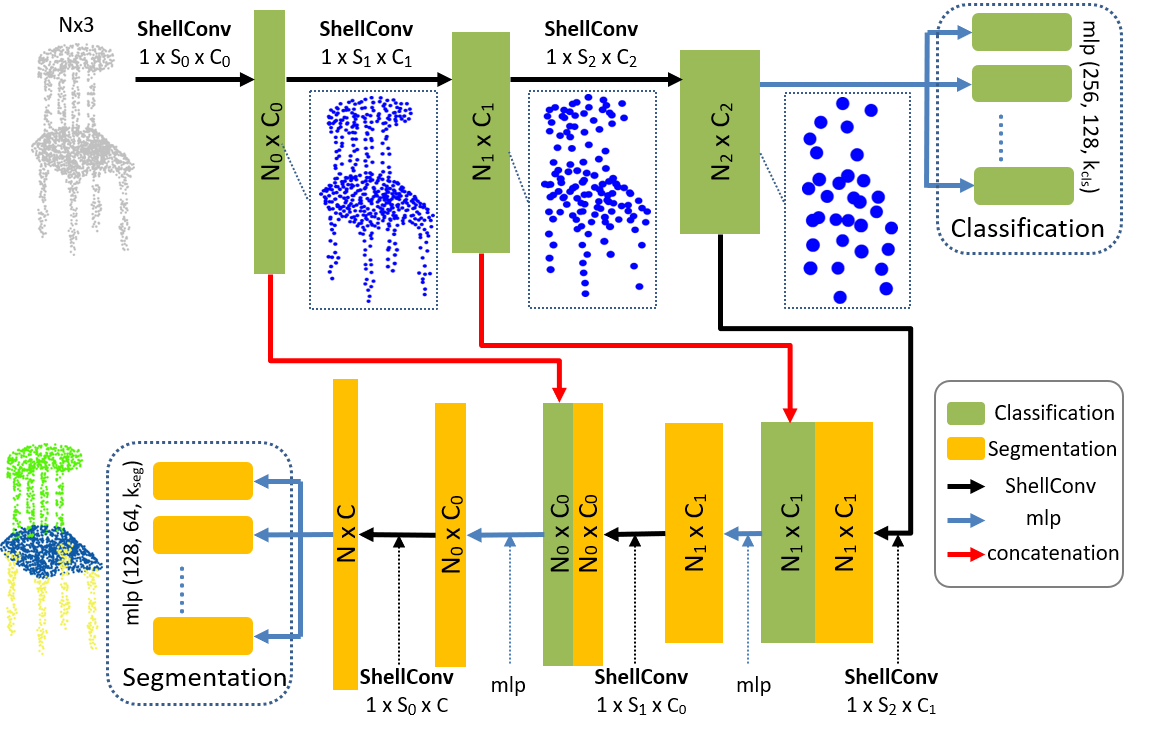

**Convolution Parameters**

1. `K` is the neighborhood size
2. `D` is number of shells
3. `P` is the representative point number in the output
4. `C` is the output channel number.  

Each tuple specifies the parameters of one `ShellConv` layer, and they are stacked to create a deep network.

**Deconvolution Parameters**
 
1. `K` is the neighborhood size 
2. `D` is number of shells
3. `pts_layer_idx` specifies the output of which `ShellConv` layer (from the `sconv_params`) will be the input of this `ShellDeConv` layer, and 
4. `qrs_layer_idx` specifies the output of which `ShellConv` layer (from the `sconv_params`) will be forwarded and fused with the output of this `ShellDeConv` layer. 
5. The `P` and `C` parameters of this `ShellDeConv` layer is also determined by `qrs_layer_idx`. 

Similarly, each tuple specifies the parameters of one `ShellDeConv` layer, and they are stacked to create a deep network.

In [ ]:
class Shellconv(keras.layers.Layer):
  
  def __init__(self, sampling, K, D, P, C, with_local, bn_decay=None):
    super(Shellconv, self).__init__()

    self.sampling = sampling
    self.K = K
    self.D = D
    self.P = P
    self.C = C
    self.with_local =with_local
    self.bn_decay = bn_decay
    self.C_pts_fts = 64
   
  def build(self, input_shape):

    self.dense1 = keras.layers.Dense(self.C_pts_fts // 2)
    self.dense2 = keras.layers.Dense(self.C_pts_fts)

    self.bn_layer1 = keras.layers.BatchNormalization(momentum=0.98)
    self.bn_layer2 = keras.layers.BatchNormalization(momentum=0.98)
    self.Conv2d = Conv2d(self.C)

    super(Shellconv, self).build(input_shape)
  
  #@tf.function(jit_compile=True)
  def call(self, pts, fts, qrs = None):

    if qrs is None:
      if self.sampling == 'fps':
        qrs = gather_point(pts, farthest_point_sample(self.P, pts))
      elif self.sampling == 'random':
        qrs = tf.slice(pts, (0, 0, 0), (-1, self.P, -1))  # (N, P, 3)
      else:
        print('Unknown sampling method!')
        exit()

    indices = knn_indices_general(qrs, pts, self.K, True)

    nn_pts = tf.gather_nd(pts, indices)  # (N, P, K, 3)
    nn_pts_center = tf.expand_dims(qrs, axis=2)  # (N, P, 1, 3)
    nn_pts_local = tf.subtract(nn_pts, nn_pts_center)  # (N, P, K, 3)

    [N,P,K,dim] = nn_pts_local.shape # (N, P, K, 3)
    
    if self.with_local:
      nn_fts_local = self.dense1(nn_pts_local)
      nn_fts_local = self.bn_layer1(nn_fts_local, training=True)
      nn_fts_local = self.dense2(nn_fts_local)
      nn_fts_local = self.bn_layer2(nn_fts_local, training=True)
    else:
      nn_fts_local = nn_pts_local

    if fts is not None:
      fts = tf.gather_nd(fts, indices)  # (N, P, K, 3)
      pts_X_0 = tf.concat([nn_fts_local,fts], axis=-1)
    else:
      pts_X_0 = nn_fts_local

    s = int(K/self.D)  # no. of divisions
    feat_max = keras.layers.MaxPool2D(pool_size=[1,s], strides=[1,s], padding='valid')(pts_X_0)

    fts_X = self.Conv2d(feat_max)
    fts_X = tf.squeeze(fts_X, axis=-2)
    
    return qrs, fts_X

In [ ]:
class Shelldeconv(keras.layers.Layer):
  
  def __init__(self, sampling, K, D, P, C, with_local, bn_decay=None):
    super(Shelldeconv, self).__init__()

    self.sampling = sampling
    self.K = K
    self.D = D
    self.P = P
    self.C = C
    self.with_local =with_local
    self.bn_decay = bn_decay
    self.C_pts_fts = 64
   
  def build(self, input_shape):

    self.dense = keras.layers.Dense(self.C)
    self.conv_layer = Shellconv(self.sampling, self.K, self.D, self.P, self.C, True, self.bn_decay)
    
    super(Shelldeconv, self).build(input_shape)
  
  #@tf.function(jit_compile=True)
  def call(self, pts, qrs, fts, fts_qrs):
        
    _, layer_fts= self.conv_layer(pts, fts, qrs)
    if fts_qrs is not None: # this is for last layer
      fts_concat = tf.concat([layer_fts, fts_qrs], axis=-1)
      fts = self.dense(fts_concat) 
    
    return fts, layer_fts

### Shellnet

In [ ]:
class Shellnet(keras.Model):

  def __init__(self, NUM_CLASSES, is_training, sampling='fps', weight_decay=0.0, bn_decay=None, **kwargs):
    super(Shellnet, self).__init__(**kwargs)
    
    self.NUM_CLASSES = NUM_CLASSES
    
    self.is_training = is_training
    self.sampling = sampling
    self.activation = tf.nn.relu
    self.weight_decay = weight_decay
    self.bn_decay = bn_decay
    
    ss = 8 # shell size (number of points contained in each shell)
    self.conv_layer1 = Shellconv(self.sampling, ss*4, 4, 512, 128, True, self.bn_decay)
    self.conv_layer2 = Shellconv(self.sampling, ss*2, 2, 256, 256, True, self.bn_decay)
    self.conv_layer3 = Shellconv(self.sampling, ss*1, 1, 128, 512, True, self.bn_decay)

    self.dconv_layer1 = Shelldeconv(self.sampling, ss*1, 1, 128, 512, True, self.bn_decay)
    self.dconv_layer2 = Shelldeconv(self.sampling, ss*2, 2, 256, 256, True, self.bn_decay)
    self.dconv_layer3 = Shelldeconv(self.sampling, ss*4, 4, 512, 128, True, self.bn_decay)
     
    self.dense1 = keras.layers.Dense(128, activation=self.activation)
    self.dropout1 = keras.layers.Dropout(0.4)
    self.dense2 = keras.layers.Dense(64, activation=self.activation)
    self.dropout2 = keras.layers.Dropout(0.2)
    self.dense3 = keras.layers.Dense(self.NUM_CLASSES, activation=tf.nn.softmax)
     
  #@tf.function(jit_compile=True) 
  def call(self, inputs):
    
    pts0, fts0 = inputs,None
    pts1, fts1 = self.conv_layer1(pts0,fts0)
    pts2, fts2 = self.conv_layer2(pts1,fts1)
    pts3, fts3 = self.conv_layer3(pts2,fts2)

    fts, _ = self.dconv_layer1(pts3,pts2,fts3,fts2)
    fts, _ = self.dconv_layer2(pts2,pts1,fts,fts1)
    fts, layer_fts = self.dconv_layer3(pts2,pts0,fts,fts0)

    net = self.dense1(layer_fts)
    net = self.dropout1(net)

    net = self.dense2(net)
    net = self.dropout2(net)

    pred = self.dense3(net)
    return pred

## Instantiate the model

In [ ]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = Shellnet(num_classes,True)
segmentation_model.build(input_shape=(None, num_points,3))
segmentation_model.summary()

Model: "shellnet_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shellconv_9 (Shellconv)     multiple                  35392     
                                                                 
 shellconv_10 (Shellconv)    multiple                  100928    
                                                                 
 shellconv_11 (Shellconv)    multiple                  166464    
                                                                 
 shelldeconv_9 (Shelldeconv)  multiple                 691264    
                                                                 
 shelldeconv_10 (Shelldeconv  multiple                 396096    
 )                                                               
                                                                 
 shelldeconv_11 (Shelldeconv  multiple                 166464    
 )                                                      

## Training

For the training the authors recommend using a learning rate schedule that decays the
initial learning rate by half every 20 epochs. In this example, we resort to 15 epochs.

Total training steps: 5520.


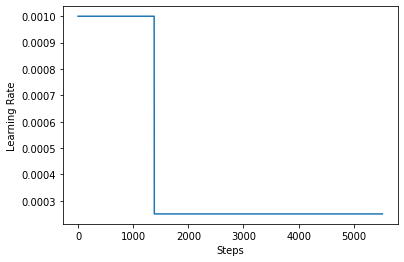

In [ ]:
training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[training_step_size * 15, training_step_size * 15],
    values=[INITIAL_LR, INITIAL_LR * 0.5, INITIAL_LR * 0.25],
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

Finally, we implement a utility for running our experiments and launch model training.

In [ ]:
def run_experiment(epochs):

  #segmentation_model = get_shape_segmentation_model(num_points, num_classes)
  segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

  history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

  segmentation_model.load_weights(checkpoint_filepath)
  return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/60
93/93 [==============================] - 64s 548ms/step - loss: 0.7955 - accuracy: 0.7280 - val_loss: 0.4992 - val_accuracy: 0.8280
Epoch 2/60
93/93 [==============================] - 47s 506ms/step - loss: 0.4960 - accuracy: 0.8349 - val_loss: 0.4511 - val_accuracy: 0.8371
Epoch 3/60
93/93 [==============================] - 47s 511ms/step - loss: 0.4584 - accuracy: 0.8425 - val_loss: 0.4216 - val_accuracy: 0.8509
Epoch 4/60
93/93 [==============================] - 47s 508ms/step - loss: 0.4307 - accuracy: 0.8493 - val_loss: 0.4003 - val_accuracy: 0.8536
Epoch 5/60
93/93 [==============================] - 47s 505ms/step - loss: 0.4120 - accuracy: 0.8546 - val_loss: 0.3820 - val_accuracy: 0.8586
Epoch 6/60
93/93 [==============================] - 47s 504ms/step - loss: 0.3998 - accuracy: 0.8573 - val_loss: 0.3827 - val_accuracy: 0.8574
Epoch 7/60
93/93 [==============================] - 47s 506ms/step - loss: 0.3895 - accuracy: 0.8606 - val_loss: 0.3922 - val_accuracy: 0.8559

## Visualize the training landscape

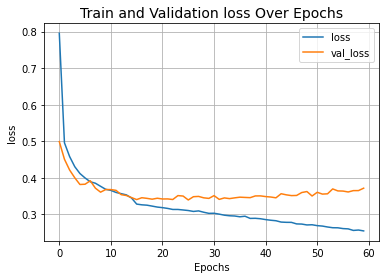

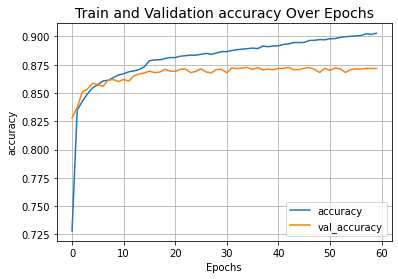

In [ ]:
def plot_result(item):
  plt.plot(history.history[item], label=item)
  plt.plot(history.history["val_" + item], label="val_" + item)
  plt.xlabel("Epochs")
  plt.ylabel(item)
  plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
  plt.legend()
  plt.grid()
  plt.show()


plot_result("loss")
plot_result("accuracy")

## Inference

Validation prediction shape: (32, 1024, 5)
Index selected: 11


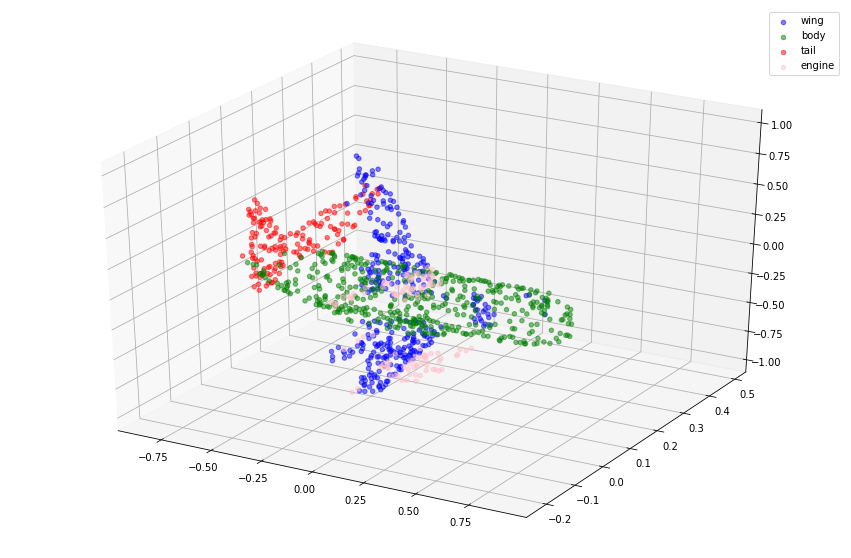

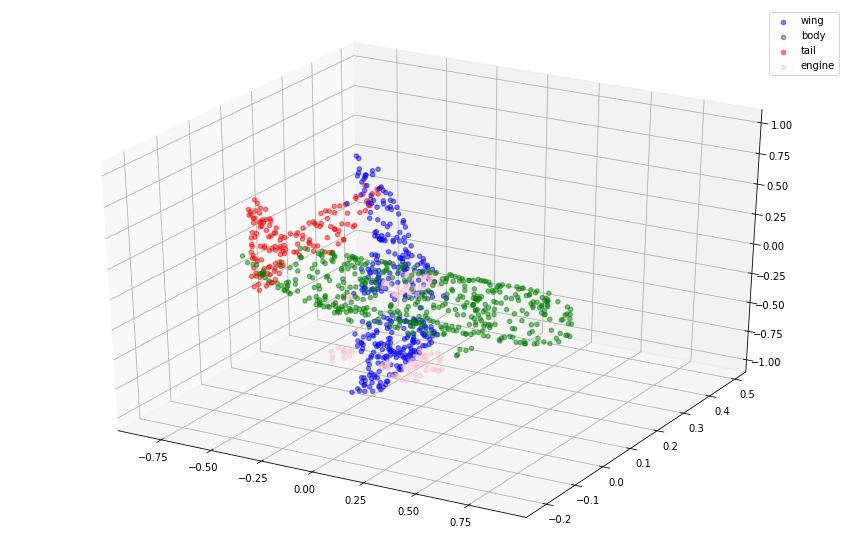

In [ ]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
  label_map = LABELS + ["none"]
  point_cloud = point_clouds[idx]
  label_cloud = label_clouds[idx]
  visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

## Final notes

If you are interested in learning more about this topic, you may find
[this repository](https://github.com/soumik12345/point-cloud-segmentation)
useful.